<a href="https://colab.research.google.com/github/skidditpapa/hello-world/blob/main/Copy_of_Testing_attention_queries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import gym
import io
import os
from scipy import sparse
from numpy import linalg as LA

# %matplotlib notebook
%matplotlib inline
env = gym.make('MountainCar-v0')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [2]:
index_s = 0
index_a = 3
index_r = 6
index_s_next = 7
index_a_next = 10
index_v = 13

In [3]:
min_position = -1.2
max_position = 0.6
max_speed = 0.07
goal_position = 0.5

force = 0.001
gravity = 0.0025

low = np.array([min_position, -max_speed], dtype=np.float32)
high = np.array([max_position, max_speed], dtype=np.float32)

def step(state, action, keep=5):
    position, velocity = state
    velocity *= 0.06
    
    terminated = False
    for i in range(keep):
        velocity += (action - 1) * force + math.cos(3 * position) * (-gravity)
        velocity = np.clip(velocity, -max_speed, max_speed)
        position += velocity
        position = np.clip(position, min_position, max_position)
        if position == min_position and velocity < 0:
            velocity = 0
        terminated = terminated or bool(position >= goal_position)
    
    reward = 0
    if(terminated):
        reward = 1

    state = (position, velocity/0.06)
    return np.array(state, dtype=np.float32), reward, terminated, {}

def value_getter(state, action, get_action, gamma = 1, tries=100):
    tot = 0
    #print(state)
    for i in range(tries):
        length = 0
        d = False
        s = state
        init = True
        while not d:
            length += 1
            #print("s is " + str(s))
            if (init):
              s, r, d, info = step(s, action)
              init = False
            else:
              #print(s)
              s, r, d, info = step(s, get_action(s))
        tot += gamma**length
        #if (i < 10):
          #print(length)
    return tot/tries


In [ ]:
replay_memory_backup[650]

NameError: ignored

In [ ]:
replay_memory[650]

In [4]:
def reset():
    return env.reset()
def step(action):
    s, r, done, info = env.step(action)
    x = 0
    if(s[0] > 0.5):
        x = 1
    return [s[0], s[1]/0.06], 0.0025*(np.sin(4*s[0])*0.45+0.55) + s[1]**2/2+x, done, info
def step2(action):
    s, r, done, info = env.step(action)
    x = 0
    if(s[0] > 0.5):
        x = 1
    return [s[0], s[1]/0.06], x, done, info
def step2(action):
    s, r, done, info = env.step(action)
    x = 0
    if(s[0] > 0.5):
        x = 1
    return [s[0], s[1]/0.06], x, s[0] > 0.5, info
def get_loss_reinforce(tot_len, states, actions, advantages, prob):
    prob_ratios = policy(states.float())[range(tot_len), actions]/prob
    return -(torch.log(prob_ratios)*advantages).mean()

In [5]:
def transform(state):
    pos = state[0]
    v_scaled = state[1]
    new_state = np.array([pos, v_scaled, 1])
    return np.ndarray.tolist(new_state/math.sqrt(new_state.dot(new_state)))

In [6]:
def one_hot(action):
    res = []
    if action == 0:
        res = [0,1,0]
    if action == -1:
        res = [1,0,0]
    if action == 1:
        res = [0,0,1]
    return res

In [7]:
def insert(replay_memory, index, state, action, reward, new_state, value):
    if (index > 0):
      replay_memory[index - 1][index_a_next:index_v] = one_hot(action)
    replay_memory[index] = state+one_hot(action)+[reward]+new_state+[0, 0, 0]+[value]
    index += 1
    if index == replay_memory.shape[0]:
        replay_memory = np.append(replay_memory, np.zeros(shape=replay_memory.shape), axis = 0)
    return replay_memory, index

In [8]:
def reinforce_value_baseline(policy, critic, discount_factor, steps, trajectories, epoches, lrp, lrc):
    rewards = []
    criterion = torch.nn.MSELoss()
    optimizer_policy = torch.optim.Adam(policy.parameters(), lr=lrp)
    optimizer_critic = torch.optim.Adam(critic.parameters(), lr=lrc)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.show()
    fig.canvas.draw()
    for k in range(steps):
        states = []
        actions = []
        advantages = []
        values = []
        prob = []
        total_len = 0

        best = 0
        ent = 0
        for i in range(trajectories):
            done = False
            single_len = 0
            s = reset()
            while not done:
                states.append(s)
                a = np.random.choice(3, 1, p=policy(torch.tensor(s).float()).detach().numpy())[0]
                prob.append(policy(torch.tensor(s).float())[a])
                actions.append(a)
                
                values.append(critic(torch.tensor(s).float())[0])
                
                s, r, done, info = step(a)
                advantages.append(r)# - policy(torch.tensor(s).float())[a])
                single_len += 1
                best += r
            total_len += single_len
            for j in range(single_len-1):
                advantages[total_len-j-2] += discount_factor*advantages[total_len-j-1]
        states = np.array(states)
        actions = np.array(actions)
        advantages = np.array(advantages)
        rewards.append(best/total_len)
        ax.clear()
        ax.plot(rewards)
        fig.canvas.draw()
        for i in range(epoches):
            optimizer_policy.zero_grad()
            loss = get_loss_reinforce(total_len, torch.tensor(states), torch.tensor(actions).long(), torch.tensor(advantages)-torch.tensor(values), torch.tensor(prob))
            loss.backward()
            optimizer_policy.step()
        optimizer_critic.zero_grad()
        y = critic(torch.tensor(states).float())
        loss = criterion(y, torch.tensor(advantages).reshape(-1,1).float())
        loss.backward()
        optimizer_critic.step()
    return rewards

In [9]:
def get_values(policy, discount_factor, steps, trajectories, epoches):
    states = []
    actions = []
    rewards = []
    total_len = 0

    for k in range(steps):
        best = 0
        for i in range(trajectories):
            done = False
            single_len = 0
            s = reset()
            while not done:
                states.append(s)
                a = np.random.choice(3, 1, p=policy(torch.tensor(s).float()).detach().numpy())[0]
                actions.append(a)
                s, r, done, info = step(a)
                rewards.append(r)
                single_len += 1
                best += r
            total_len += single_len
            for j in range(single_len-1):
                rewards[total_len-j-2] += discount_factor*rewards[total_len-j-1]
    return states, actions, rewards, total_len

In [ ]:
p = nn.Sequential(
        nn.Linear(2, 7, bias=False),
        nn.ReLU(inplace=True),
        nn.Linear(7, 3, bias=False),
        nn.Softmax(dim=-1),)

In [ ]:
discount_factor = 0.97
steps = 100
trajectories = 100
epoches = 5
lr = 0.01

In [ ]:
states, actions, advantages, total_len = get_values(p, discount_factor, steps, trajectories, epoches)

advantages = np.array(advantages).reshape(-1,1)
states = np.array(states)
actions = (np.array(actions)-1).reshape(-1,1)

KeyboardInterrupt: ignored

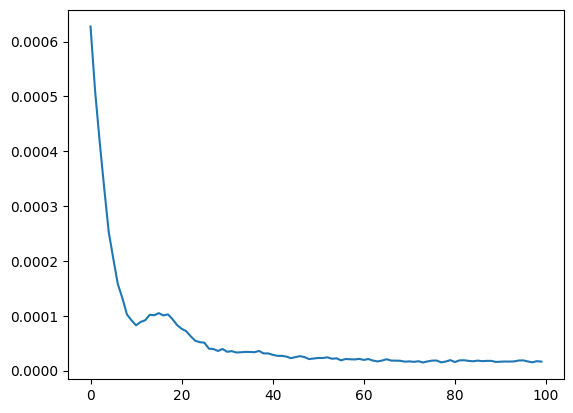

In [ ]:
c = nn.Sequential(
        nn.Linear(2, 7, bias=False),
        nn.ReLU(inplace=True),
        nn.Linear(7, 1, bias=False),)

l = []
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(c.parameters(), lr=0.005)

for i in range(100):
    optimizer.zero_grad()
    idx = np.random.randint(states.shape[0], size=1000)
    y = c(torch.tensor(states[idx]).float())
    loss = criterion(y, torch.tensor(advantages[idx]).float())
    l.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()
ax.clear()
ax.plot(l)
fig.canvas.draw()
plt.show()


In [ ]:
# bufferp = io.BytesIO()
# torch.save(p,bufferp)

In [ ]:
# bufferp.seek(0)
#policy = torch.load(bufferp)
policy = p
reinforce_value_baseline(policy, c, discount_factor, steps, trajectories, epoches, lr, 0.1)

NameError: ignored

In [ ]:
# p.save('./checkpoints/my_checkpoint')
torch.save(p, './policy')

NameError: ignored

In [10]:
policy = torch.load('./policy')
policy_bad = torch.load('./policy_bad')

In [11]:
def step(state, action, keep=5):
    position, velocity = state
    velocity *= 0.06
    
    terminated = False
    for i in range(keep):
        velocity += (action - 1) * force + math.cos(3 * position) * (-gravity)
        velocity = np.clip(velocity, -max_speed, max_speed)
        position += velocity
        position = np.clip(position, min_position, max_position)
        if position == min_position and velocity < 0:
            velocity = 0
        terminated = terminated or bool(position >= goal_position)
    
    reward = 0
    if(terminated):
        reward = 1

    state = (position, velocity/0.06)
    return np.array(state, dtype=np.float32), reward, terminated, {}

In [12]:
def fill_replay_memory(replay_memory, index, gamma, steps):
  end_index = index
  end_traj = []
  for k in range(20):
      s = reset()
      start_index = 0
      r_sum = 0
      runs = 0
      weight = 1
      d = False
      replay_memory_tmp = np.zeros(replay_memory.shape)
      while not d:
          runs += 1
          
          if runs > 2*steps:
              #print("runs is " + str(runs))
              replay_memory_tmp[index-2*steps, -1] = r_sum
              break
          # if (runs % 3 != 0):
          #   a = np.random.choice(3, 1, p=policy(torch.tensor(s).float()).detach().numpy())[0]
          # else:
          #   a = np.random.choice(3, 1, [1, 1, 1])[0]

          p = np.random.uniform()
          if(p < 0.8):
            a = np.random.choice(3, 1, p=policy(torch.tensor(s).float()).detach().numpy())[0]
          else:
            a = np.random.choice(3, 1, p=policy_bad(torch.tensor(s).float()).detach().numpy())[0]
          # a = np.random.choice(3, 1, p=policy(torch.tensor(s).float()).detach().numpy())[0]
          s_new, r, d, i = step(s, a)

          replay_memory_tmp, index = insert(replay_memory_tmp, index, transform(s), a-1, r, transform(s_new), r)
          # (replay_memory, index, state, action, reward, new_state, value)
          s = s_new
              # state, action, reward, new state, new action, value
          if(runs == 2*steps or d):
              r_sum = r
      #print(runs)
      for i in range(2*steps):
          if index-i-1 < start_index:
              break
          replay_memory_tmp[index-i-1, index_v] = r_sum
          r_sum *= gamma
      while(((min(index, steps))+end_index) > replay_memory.shape[0]):
         replay_memory = np.append(replay_memory, np.zeros(shape=replay_memory.shape), axis = 0)
      # print("index: " + str(index))
      # print("end_index: " + str(end_index))
      # print(replay_memory.shape)
      replay_memory[end_index:(end_index + min(index, steps))] = replay_memory_tmp[:(min(index, steps))]
      end_index += min(index, steps)
      end_traj.append(end_index)
      #print(replay_memory_tmp[index-1])
      index = 0
  return replay_memory, end_index, end_traj

In [13]:
def fill_replay_memory_allen(replay_memory, index, gamma, steps):
  for k in range(10):
      s = reset()
      start_index = index
      r_sum = 0
      runs = 0
      quo = 0
      skip = 10
      d = False
      a = 0
      while quo < 2*steps and not d:
          runs += 1
          
          if(runs % 3 != 0):
              a = np.random.choice(3, 1, p=policy(torch.tensor(s).float()).detach().numpy())[0]
          else:
              a = np.random.choice(3, 1, p=[0.33, 0.33, 0.34])[0]
          s_new, r, d, i = step2(a)

          if(quo < 200):
              replay_memory, index = insert(replay_memory, index, transform(s), a-1, r, transform(s_new), r)
          s = s_new

          if(quo >= 2*steps or d):
              r_sum = r
          quo += 1
      for i in range(index-start_index):
          replay_memory[start_index+i, -1] = r_sum*(gamma**(runs-i-1))
  return replay_memory, index

In [14]:
size_replay_memory = 14
replay_memory = np.zeros((1, size_replay_memory))
index = 0
gamma = 0.98**5
steps = 100
replay_memory, index, end_traj = fill_replay_memory(replay_memory, index, gamma, steps)

In [15]:
index

577

In [ ]:
replay_memory[157]

array([-0.40088093,  0.08073743,  0.91256559,  0.        ,  0.        ,
        1.        ,  0.        , -0.37572462,  0.10358059,  0.92092457,
        0.        ,  0.        ,  1.        ,  0.10835983])

In [ ]:
np.where(replay_memory[:, index_r] == 1)[0].shape[0]

20

In [ ]:
np.where(replay_memory[:index, -1] == 0)[0].shape[0]

0

In [16]:
def get_self_values(M, V, beta=1):
    e = np.exp(beta*M@M.T)
    p = e/np.sum(e, axis=1, keepdims=True)
    return p@V
def get_value(Q, K, V, beta=1):
    e = np.exp(beta*Q@K.T)
    p = e/np.sum(e, axis=1, keepdims=True)
    return p@V
alpha = 1
beta = 50
def backup(V_estimate, R, Q, K, V):
    return V_estimate*(1-alpha) + alpha*(R + get_value(Q, K, V, beta))

In [17]:
def Q_estimate(replay_memory, states, actions, index, beta, values):
    s_a = np.concatenate((states, actions), axis=1)
    f = s_a @ replay_memory[:index, 0:6].T
    f = f - np.max(f,axis=1)[:,None]
    f = np.exp(beta*f)
    f = np.divide(f, f.sum(axis=1)[:,np.newaxis])
    return np.sum(np.transpose(values)*f,axis=1),f
def backup(replay_memory, index, weighted_states, alpha, beta):
  n = index
  actions = np.array([one_hot(0), one_hot(-1),one_hot(1)])
  actions = np.tile(actions,n).reshape(3*n,3)
  states = np.repeat(replay_memory[:index, 7:10], repeats=3, axis=0)

  Qvals,a1 = Q_estimate(replay_memory, states,actions,index,beta,weighted_states)
  Qvals = Qvals.reshape(((int)(Qvals.shape[0]/3),3))
  actionprobs = Qvals - np.max(Qvals,axis=1)[:,None]
  gamma = 0.996
  actionprobs = np.exp(alpha*actionprobs)
  actionprobs = np.divide(actionprobs, actionprobs.sum(axis=1)[:,np.newaxis])
  values = np.sum(Qvals*actionprobs,axis=1)
  rewards = replay_memory[:index,6]
  values = gamma*values+rewards
  # values = -values*rewards
  for i in range(n):
      replay_memory[i][-1]=values[i]
  return replay_memory

def attention_matrix(replay_memory,index,beta):
    next_state = replay_memory[0:index,7:10]
    weighted_state = np.exp(beta*np.matmul(next_state, np.transpose(next_state)))
    weighted_state = np.divide(weighted_state, weighted_state.sum(axis=1)[:,np.newaxis])
    return weighted_state

def weighted_values(replay_memory, weighted_states,index):
    return np.matmul(weighted_states,replay_memory[0:index,-1])

In [18]:
def backup():
  Q = replay_memory_backup[:index, index_s_next:index_v]
  K = replay_memory_backup[:index, index_s:index_r]
  V = replay_memory_backup[:index, index_v]
  f = Q@K.T
  f = f - np.max(f,axis=1)[:,None]
  e = np.exp(beta*f)
  p = e/np.sum(e, axis=1, keepdims=True)
  # new_V = p@V
  # replay_memory_backup[:index, index_v] = gamma * new_V + replay_memory[:index, index_r]
  # for i in np.where(replay_memory[:, index_r] == 1):
  #   replay_memory_backup[i, -1] = replay_memory[i, -1]
  # return replay_memory_backup
  return p 

In [19]:
def find_bucket(x, A, W, b, m, bucket_indices, amplify, replicate=1):
  elem = np.concatenate((np.eye(2*m),-np.eye(2*m)))
  phi = W@x +b 
  # print(phi)
  phi = np.concatenate((np.sin(phi),np.cos(phi)))
  rotated = [A[i]@(phi.T) for i in range(replicate)]

  # rotated = A@x
  rotated = [rotated[i] / np.sqrt(np.sum(np.square(rotated[i]),axis =1))[:,None] for i in range(replicate)]
  concat_bucket = set()
  # print(rotated.shape)
  for j in range(replicate): 
    bucket = 0 
    for i in range(amplify):
      dists = elem - rotated[j][i]
      dists = np.sum(np.square(dists),axis=1)
      bucket = bucket *4*m + np.argmin(dists)
    concat_bucket.union(bucket_indices[j][i])
  return list(concat_bucket), phi 

def split(replay, length, m, amplify, replicate=1, d=4):
  num_buckets = (4*m)**amplify 
  # indices = [[0 for i in range(num_buckets)] for j in range(replicate)]
  bucket_indices = [[set() for i in range(num_buckets)] for j in range(replicate)]
  
  sigma = 1
  W = np.random.multivariate_normal(np.zeros(d),sigma* np.identity(d),m) 

  A = [np.array([np.random.normal(0,1,(2*m,2*m)) for i in range(amplify)]) for j in range(replicate)] #im not sure if this is right
  b = np.random.uniform(0,2*np.pi,m) 
  
  elem = np.concatenate((np.eye(2*m),-np.eye(2*m)))
  phi = np.matmul(replay[:length,:d],np.transpose(W))+b
  phi = np.concatenate((np.sin(phi),np.cos(phi)), axis=1)
  print(phi.shape)
  rotation = [A[j]@(phi.T) for j in range(replicate)]
  rotations = [np.transpose(rotation[j],[0,2,1]) for j in range(replicate)]
  normed = [rotations[j] / np.sqrt(np.sum(np.square(rotations[j]),axis =2))[:,:,None] for j in range(replicate)]
  
  for i in range(length): 
      # rotated = np.matmul(A[0],phi[i])
      # rotated = rotation[i]
      # norm = np.sum(np.square(rotated))**.5
      for k in range(replicate):
        bucket = 0 
        for j in range(amplify):
          dists = elem - normed[k][j][i]
          dists = np.sum(np.square(dists),axis=1)
          bucket = bucket*4*m + np.argmin(dists)
          # bucket_indices[k][bucket][indices[k][bucket]] = i
          bucket_indices[k][bucket].add(i)
          # indices[k][bucket] += 1  

  return bucket_indices, A, W, b

In [20]:
def performer(queries, beta, tests, states, d, kernel='trig'):
    beta = beta
    # tests = 1000
    preds = np.empty((tests, 1)) # attention
    performer = np.empty((tests, 1))
    reward_preds = np.empty((tests, 1)) # true rewards
    # states = np.empty((tests, bandit_dim + 1))
    # initialize performer
    l = 2
    m = 1024 * int(math.sqrt(d))
    w = np.random.multivariate_normal(mean=np.zeros(d), cov=np.identity(d), size=(m)) # shape: m * 4
    def ortho_random(m, d, ortho=False, s=1):
        if ortho:
            #less bugged
            W = np.random.multivariate_normal(np.zeros(d), s*np.identity(d), (math.ceil(m/d), d))
            W, _ = np.linalg.qr(W)
            W = W.reshape(-1, d)
            W = np.vstack(W)
            #mult = np.sqrt(d)
            mult = np.linalg.norm(np.random.multivariate_normal(np.zeros(d), s*np.identity(d), (m)), axis=1).reshape(-1, 1)
            W = W[0:m]*mult
        else:
            W = np.random.multivariate_normal(np.zeros(d), s*np.identity(d), (m))
            #mult = np.linalg.norm(W, axis=1).reshape(-1, 1)
            #W = np.sqrt(d)*W/mult

        return W[0:m]
    w = ortho_random(m, d, True)
    
    def phi(x, kernel='trig'):
        tmp = x@w.T
        norms = LA.norm(x, axis=1)
        scaler = 0 
        if kernel == 'trig':
            tmp1 = np.sin(tmp)
            tmp2 = np.cos(tmp)
            tmp = np.concatenate((tmp1, tmp2), axis=1)
            # print(norms.shape)
            # norms = norms - np.max(norms)
            tmp = (tmp.T * np.exp(norms**2/2)).T
        elif kernel == 'exp':
            tmp1 = np.exp(tmp)
            tmp2 = np.exp(-tmp)

            tmp = np.concatenate((tmp1, tmp2), axis=1)
            scaled_norms = -(norms**2/2)
            scaler = np.max(scaled_norms)
            scaled_norms = scaled_norms - np.max(scaled_norms)
            tmp = (tmp.T *np.exp(scaled_norms)).T
            tmp /= math.sqrt(2)
        elif kernel == 'exp_1':
            tmp1 = np.exp(tmp)
            tmp = (tmp.T * np.exp(-norms**2/2)).T 
         # trials * m
        
        tmp /= math.sqrt(m)
        # print(tmp.shape,norms.shape)
        return tmp, scaler
    
# performers
    phi_s, query_scale = phi(math.sqrt(beta) * states, kernel)
    phi_buffer, keys_scale = phi(math.sqrt(beta) * queries, kernel)
    # prod = (phi_buffer @ phi_s.T)
#     prod = np.power(prod, beta)
    # performer_raw_weights = prod
    #prod /= np.sum(prod, axis=0) # normalization
    return phi_buffer,query_scale, phi_s, keys_scale

def combined(keys, index, sa, values, bucket_indices, A_lsh, W_lsh, b_lsh, m_lsh, amplify, replicate, beta = 1): 
  # print("start")
  mapped_memory, q_scale, mapped_sa, k_scale = performer(keys, beta, sa.shape[0], sa, keys.shape[1], kernel = 'exp')
  # print("end")
  # print(mapped_memory.shape, mapped_sa.shape) 
  sparse_attention = np.zeros((sa.shape[0],index))
  # print('start')

  for i,entry in enumerate(sa): 
    bucket, _ =  find_bucket(entry, A_lsh, W_lsh, b_lsh, m_lsh, bucket_indices, amplify, replicate)
    # attention_mult = np.exp(sa[i] @ replay_memory[bucket_indices[bucket][:bucket_lengths[bucket]]].T)
    # approx_mult = mapped_sa[i] @ mapped_memory[bucket_indices[bucket][:bucket_lengths[bucket]]].T

    # for k,j in enumerate(bucket_indices[bucket][:bucket_lengths[bucket]]):
    #     # sparse_attention[i][int(j)] = 1
    #     # sparse_attention[i][int(j)] = np.exp(beta * sa[i]@replay_memory[int(j)].T) - mapped_sa[i] @ mapped_memory[int(j)]
    #     sparse_attention[i][int(j)] = attention_mult[k] - approx_mult[k]
    attention_mult = np.exp(beta * (sa[i] @ keys[bucket].T)-q_scale-k_scale)
    approx_mult = mapped_sa[i] @ mapped_memory[bucket].T

    for k,j in enumerate(bucket): 
        # sparse_attention[i][intj)] = 1
        # sparse_attention[i][int(j)] = np.exp(beta * sa[i]@replay_memory[int(j)].T) - mapped_sa[i] @ mapped_memory[int(j)]
        sparse_attention[i][int(j)] = attention_mult[k] - approx_mult[k]

  # print('end')
  sparse_attention = sparse.csr_matrix(sparse_attention)
  normalization = mapped_sa@(mapped_memory.T @ np.ones((index,1)))
  normalization += sparse_attention @ np.ones((index,1))
  # print(normalization.shape)
  predictions = mapped_memory.T @ values
  predictions = mapped_sa @ predictions
  # return mapped_sa@mapped_memory.T+sparse_attention,(predictions + sparse_attention @ rewards)[:,None]/normalization
  # return (predictions + sparse_attention @ values)[:,None]/normalization
  return ((mapped_sa@ mapped_memory.T ) + sparse_attention)/normalization
# def combined(keys, index, sa, values, bucket_indices, A_lsh, W_lsh, b_lsh, m_lsh, amplify, replicate, beta = 1): 
#   mapped_memory, mapped_sa = performer(keys, beta, sa.shape[0], sa, keys.shape[1])
#   normalization = mapped_sa@(mapped_memory.T @ np.ones((index,1)))

#   predictions = mapped_memory.T @ values
#   predictions = mapped_sa @ predictions
#   # return mapped_sa@mapped_memory.T+sparse_attention,(predictions + sparse_attention @ rewards)[:,None]/normalization
#   return predictions[:,None]/normalization

In [ ]:
np.array([[1,2,3,4],[1,2,3,4],[1,2,3,4]]).T + np.array([1,2,3])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7]])

In [49]:
def fast_backup(m_lsh, amp_lsh, repl_lsh): 
  Q = replay_memory_backup[:index, index_s_next:index_v]
  K = replay_memory_backup[:index, index_s:index_r]
  V = replay_memory_backup[:index, index_v]
  R = replay_memory_backup[:index, index_r]
  pred = combined(K, index, Q, V, bucket_indices, A, W, b, m_lsh, amp_lsh, repl_lsh, beta)
  return pred 
  # replay_memory_backup[:index, index_v] = gamma * pred.squeeze() + R
  # for i in np.where(replay_memory[:, index_r] == 1):
  #   replay_memory_backup[i, -1] = replay_memory[i, -1]
  # return replay_memory_backup

In [77]:
m_lsh = 5
amp = 2
repl = 2
beta = 10
replay_memory_backup = np.copy(replay_memory)

bucket_indices, A, W, b = split(replay_memory_backup[:index, index_s:index_r], index, m_lsh, amp, repl, index_r-index_s)

np.sum(np.square(fast_backup(m_lsh,amp,repl)-backup()))

(5, 6)
(577, 10)
(577, 4096) (577,)
(577, 4096) (577,)


2.8138107414144

In [ ]:
from tqdm import tqdm
beta= 1200
replay_memory_backup = np.copy(replay_memory)
m_lsh = 10
amp = 2
repl = 2
bucket_indices, A,  W, b = split(replay_memory_backup[:index, index_s:index_r], index, m_lsh, amp, repl, index_r-index_s)
for i in tqdm(range(100)):
  # replay_memory_backup = backup() # backup(replay_memory, index, weighted_states, alpha, beta)
  replay_memory_backup = fast_backup(m_lsh,amp,repl) # backup(replay_memory, index, weighted_states, alpha, beta)
# 
# replay_memory_backup[:index,-1]

NameError: ignored

In [ ]:
lsh_vals = np.copy(replay_memory_backup[:index,-1])

In [ ]:
lsh_vals

array([0.22700977, 0.22699989, 0.22698371, 0.22698037, 0.2269801 ,
       0.22698008, 0.4727109 , 0.22698008, 0.4727109 , 0.4727109 ,
       0.4727109 , 0.4727109 , 0.4727109 , 0.4727109 , 0.4727109 ,
       0.22960631, 0.22945764, 0.22932399, 0.22932399, 0.22931697,
       0.22703388, 0.22698009, 0.4727109 , 0.4727109 , 0.4727109 ,
       0.4727109 , 0.70335248, 0.47271091, 0.48683472, 0.70335553,
       0.90287298, 1.        , 0.4727109 , 0.22702061, 0.22717965,
       0.2275841 , 0.22724495, 0.22699925, 0.22698057, 0.22698009,
       0.4727109 , 0.4727109 , 0.22978197, 0.4727109 , 0.4727109 ,
       0.4727109 , 0.4727109 , 0.47271093, 0.47276286, 0.53418718,
       0.86970583, 0.89647838, 0.22959425, 0.22960645, 0.22932534,
       0.22932399, 0.22932399, 0.22906274, 0.22698092, 0.4727109 ,
       0.22698008, 0.4727109 , 0.4727109 , 0.4727109 , 0.4727109 ,
       0.47646521, 0.90191006, 0.90283886, 1.        , 0.23011017,
       0.22701264, 0.22703291, 0.23011035, 0.4727109 , 0.47271

In [ ]:
from tqdm import tqdm
beta=1200
replay_memory_backup_ref = np.copy(replay_memory)
# m_lsh = 10
# amp = 1
# repl = 1
# bucket_indices, A, W, b = split(replay_memory_backup[:index, index_s:index_r], index, m_lsh, amp, repl, index_r-index_s)
for i in tqdm(range(100)):
  replay_memory_backup = backup() # backup(replay_memory, index, weighted_states, alpha, beta)
  # replay_memory_backup = fast_backup(m_lsh,amp,repl) # backup(replay_memory, index, weighted_states, alpha, beta)
# 
# replay_memory_backup[:index,-1]

100%|██████████| 100/100 [00:01<00:00, 63.62it/s]


In [ ]:
def rmse(A, B):
  return math.sqrt((( A-B)**2).mean(axis=0))

In [ ]:
rmse(replay_memory_backup[:index,-1], replay_memory[:index,-1])

0.058532597834356506

In [ ]:
rmse(replay_memory_backup[:index,-1], lsh_vals)

0.2962453615771363

In [ ]:
replay_memory_backup[150]

array([0.35439261, 0.47523094, 0.80533312, 0.        , 0.        ,
       1.        , 0.        , 0.37830162, 0.47417563, 0.7950128 ,
       0.        , 0.        , 1.        , 0.96459313])

In [ ]:
replay_memory[0]

array([-0.46344027,  0.        ,  0.88612816,  0.        ,  0.        ,
        1.        ,  0.        , -0.46269712,  0.0147063 ,  0.88639444,
        0.        ,  0.        ,  1.        ,  0.09218854])

In [ ]:
np.where(replay_memory[0, index_a:index_r]==1)

(array([2]),)

In [ ]:
def get_action(s):
      p = np.random.uniform()
      if(p < 0.8):
        a = np.random.choice(3, 1, p=policy(torch.tensor(s).float()).detach().numpy())[0]
      else:
        a = np.random.choice(3, 1)[0]
      return a

In [ ]:
def testing_true_value_vs_backup(end_state, init_state, tries):
  true_values = []
  for i in tqdm(range(init_state, end_state)):
    
    test_state = replay_memory_backup[i][index_s:index_a]/replay_memory_backup[i][index_s:index_a][-1]
    #print("test state is " + str(test_state))
    #-0.64461268, -0.03827171,  0.76355076
    
    #get_action(test_state[:-1])
    test_action = np.where(replay_memory[i][index_a:index_r]==1)[0][0]-1
    #print(test_action)
    true_values.append(value_getter(test_state[:-1], test_action, get_action, gamma, tries))
  return true_values

In [ ]:
start_i = 0
end_i = index

In [ ]:
true_values = testing_true_value_vs_backup(end_i, start_i, 100)

100%|██████████| 628/628 [07:01<00:00,  1.49it/s]


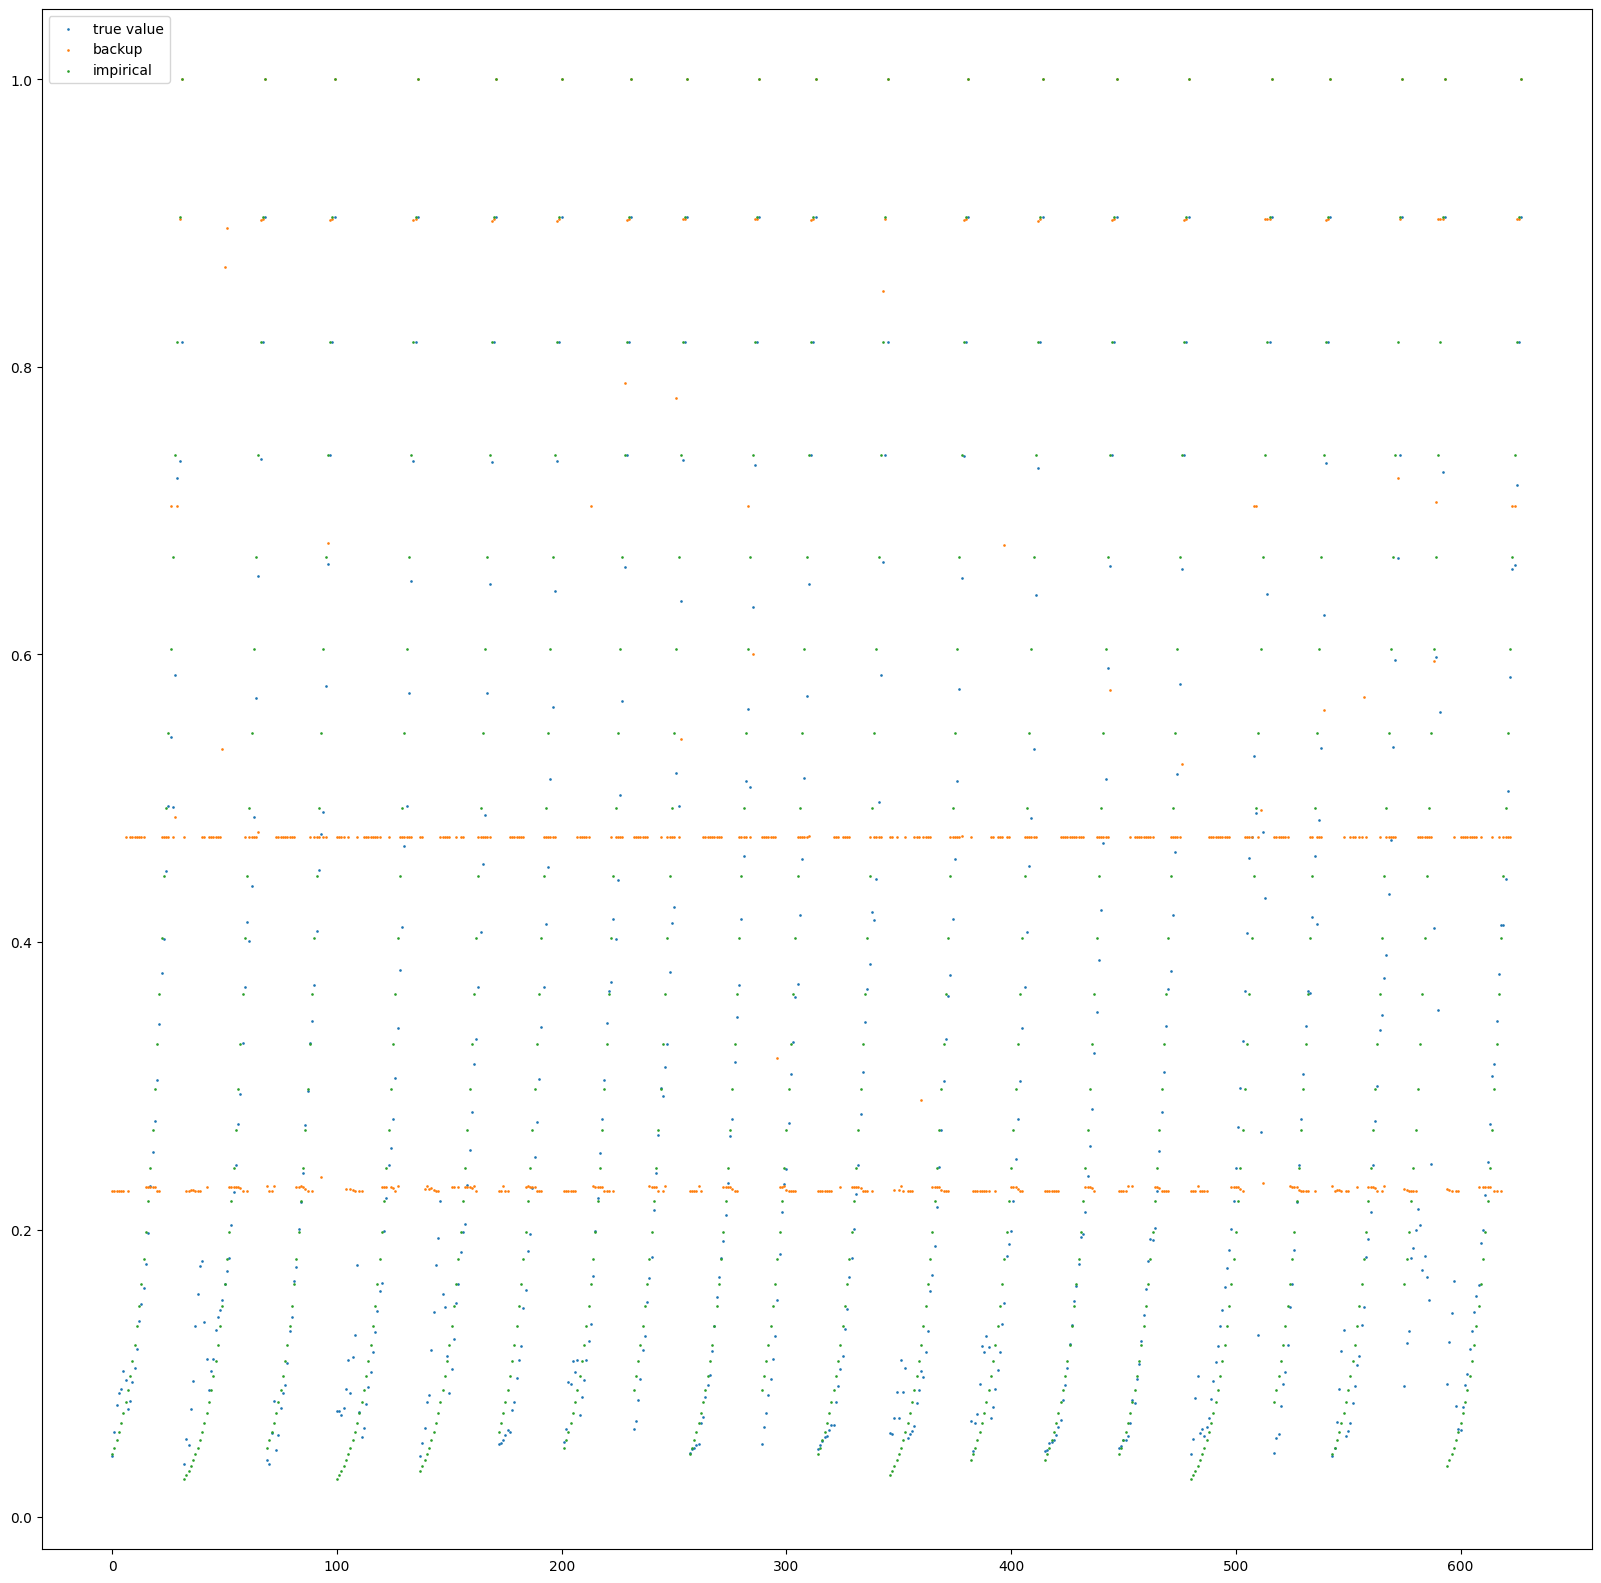

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
x = [i for i in range(start_i, end_i)]
plt.scatter(x, true_values[start_i:end_i], s=0.8, label='true value')
plt.scatter(x, replay_memory_backup[start_i:end_i, -1], s=0.8, label="backup")
plt.scatter(x, replay_memory[start_i:end_i, -1], s=0.8, label="impirical")
plt.legend()
plt.show()

In [ ]:
rmse_backup = rmse(true_values, replay_memory_backup[:index, -1])
rmse_no_backup = rmse(true_values, replay_memory[:index, -1])
print(rmse_backup)
print(rmse_no_backup)
print(100*abs(rmse_backup-rmse_no_backup)/rmse_no_backup)

0.179230988503444
0.12030957661857047
48.97483104913417


In [ ]:
test_replay_memory = np.zeros((1, size_replay_memory))
test_index = 0
test_steps = steps
test_replay_memory, test_index, end_indoces = fill_replay_memory(test_replay_memory, test_index, gamma, steps)

In [ ]:
def attention(Q, K, V):
  f = Q@K.T
  f = f - np.max(f,axis=1)[:,None]
  e = np.exp(beta*f)
  p = e/np.sum(e, axis=1, keepdims=True)
  return p@V

In [ ]:

  
test_Q = test_replay_memory[0:test_index, index_s:index_r]
test_K = replay_memory[0:index, index_s:index_r]
pred_backup = attention(test_Q, test_K, replay_memory_backup[:index, -1])
pred = attention(test_Q, test_K, replay_memory[:index, -1])
rmse_backup = rmse(test_replay_memory[0:test_index, -1], pred_backup)
rmse1 = rmse(test_replay_memory[0:test_index, -1], pred)
  # math.sqrt((( test_replay_memory[0:test_index, -1]- pred_backup)**2).mean(axis=0))
  # rmse = math.sqrt((( test_replay_memory[0:test_index, -1]- pred)**2).mean(axis=0))
  

In [ ]:

  
test_Q = test_replay_memory[0:test_index, index_s:index_r]
test_K = replay_memory[0:index, index_s:index_r]
pred_backup = attention(test_Q, test_K, replay_memory_backup[:index, -1])
pred = attention(test_Q, test_K, replay_memory[:index, -1])
pred_true = attention(test_Q, test_K, true_values)
rmse_backup = rmse(test_replay_memory[0:test_index, -1], pred_backup)
rmse1 = rmse(test_replay_memory[0:test_index, -1], pred)
rmse_true = rmse(test_replay_memory[0:test_index, -1], pred_true)
  # math.sqrt((( test_replay_memory[0:test_index, -1]- pred_backup)**2).mean(axis=0))
  # rmse = math.sqrt((( test_replay_memory[0:test_index, -1]- pred)**2).mean(axis=0))
  

In [ ]:
end_i = test_index
start_i = 0

test_true_values = testing_true_value_vs_backup(end_i, start_i, 100)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 578/578 [07:00<00:00,  1.38it/s]


In [ ]:
rmse_backup = rmse(test_true_values, pred_backup)
rmse_no_backup = rmse(test_true_values, pred)
rmse_empirical = rmse(test_true_values, test_replay_memory[:test_index, -1])
print(rmse_backup)
print(rmse_no_backup)
print(rmse_empirical)
print(100*abs(rmse_backup-rmse_no_backup)/rmse_no_backup)

ValueError: ignored

In [ ]:
rmse_backup

0.12168648116390318

In [ ]:
rmse1

0.12292515600453283

In [ ]:
rmse_true

0.1484898991049103

In [ ]:
(rmse1-rmse_backup)/rmse1

0.010076658683141868

<ipython-input-48-f6590bdbb7f8>:4: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter(test_replay_memory[:index, 0]/test_replay_memory[:index, 2],test_replay_memory[:index, 1]/test_replay_memory[:index, 2], s=2)


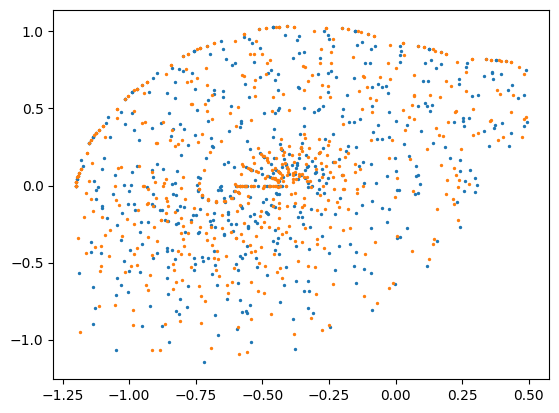

In [ ]:
f1 = plt.figure()
ax = f1.add_subplot(111)
ax.scatter(replay_memory[:index, 0]/replay_memory[:index, 2],replay_memory[:index, 1]/replay_memory[:index, 2], s=2)
ax.scatter(test_replay_memory[:index, 0]/test_replay_memory[:index, 2],test_replay_memory[:index, 1]/test_replay_memory[:index, 2], s=2)

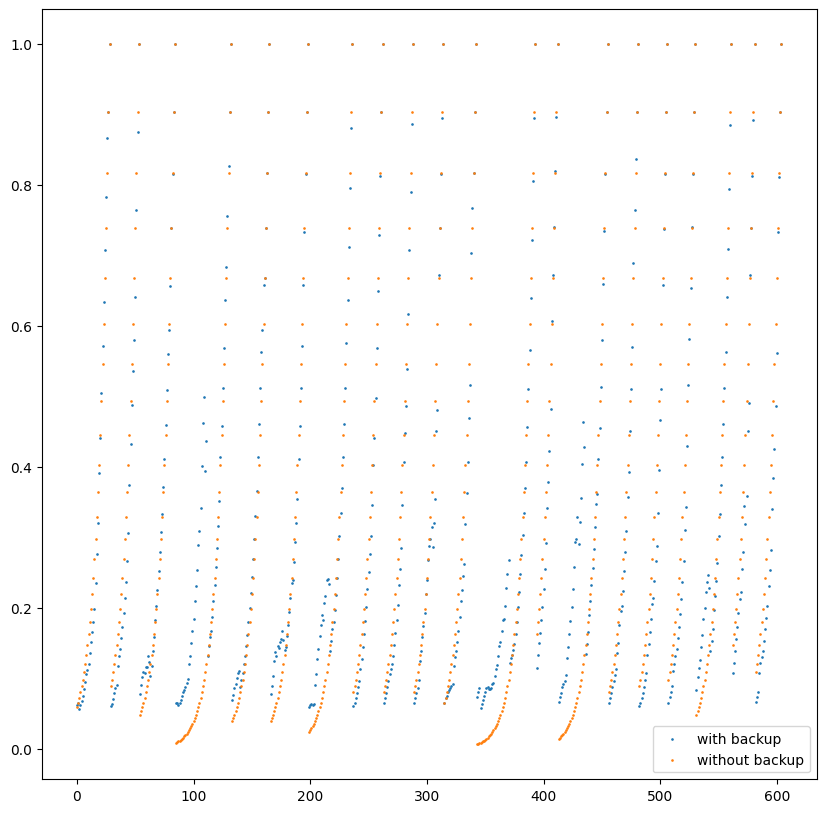

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.array([i for i in range(index)])
plt.figure(figsize=(10,10))
plt.scatter(x, replay_memory_backup[:index,-1], s=0.8, label='with backup')
plt.scatter(x, replay_memory[:index,-1], s=0.8, label='without backup')
plt.legend()
plt.show()

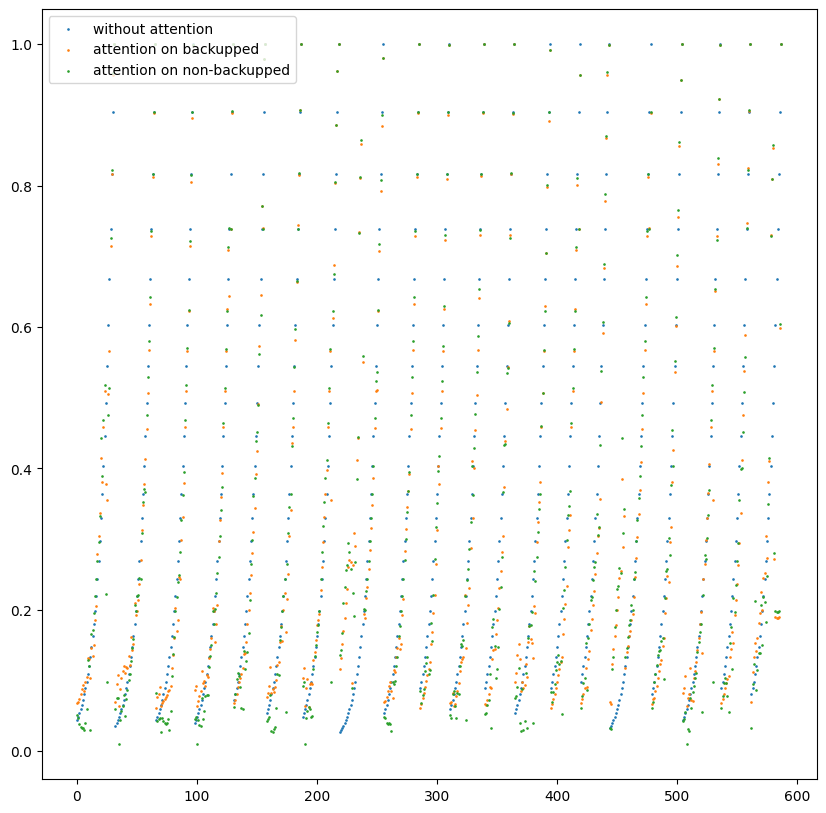

In [ ]:
x = np.array([i for i in range(test_index)])
plt.figure(figsize=(10,10))
plt.scatter(x, test_replay_memory[0:test_index, -1], s=0.8, label='without attention')
plt.scatter(x, pred_backup, s=0.8, label='attention on backupped')
plt.scatter(x, pred, s=0.8, label='attention on non-backupped')
plt.legend()
plt.show()

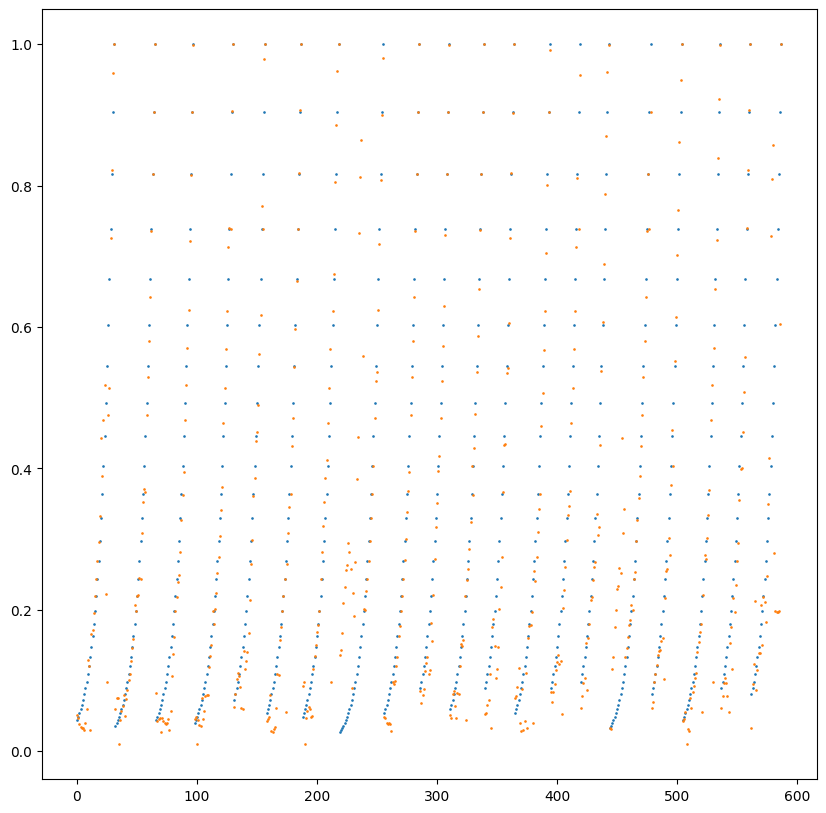

In [ ]:
#x = np.array([i for i in range(test_index)])
plt.figure(figsize=(10,10))
plt.scatter(x, test_replay_memory[0:test_index, -1], s=0.8, label='without attention')
#plt.scatter(pred, pred_backup, s=0.8, label='nonbackupped vs backupped')
plt.scatter(x, pred, s=0.8, label='attention on non-backupped')
#plt.legend()
plt.show()

In [ ]:
pred_backup

array([0.04866471, 0.05536769, 0.06453957, ..., 0.94503801, 0.96204195,
       0.97653228])

In [ ]:
pred

array([0.03456858, 0.03779492, 0.04135933, ..., 0.96295376, 0.97696449,
       0.98699584])

DEAD CODE BELOW

In [ ]:
from tqdm import tqdm
beta=300
alpha = 10
replay_memory_backup = np.copy(replay_memory)
for i in tqdm(range(50)):
  weights = attention_matrix(replay_memory_backup,index,beta)
  values = weighted_values(replay_memory_backup,weights,index)
  replay_memory_backup = backup(replay_memory_backup,index,values,alpha,beta) # backup(replay_memory, index, weighted_states, alpha, beta)
replay_memory_backup[:index,-1]

100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


array([0.09213223, 0.09232656, 0.0923397 , ..., 0.13636038, 0.13668862,
       1.13694009])

In [ ]:
replay_memory[:index,-1]

array([0.02833302, 0.0292093 , 0.03011268, ..., 0.9409    , 0.97      ,
       1.        ])

In [ ]:
def backup_Q(replay_memory, index, beta, alpha):
  n = replay_memory.shape[0]
  actions = np.array([one_hot(0), one_hot(-1),one_hot(1)])
  actions = np.tile(actions,n).reshape(3*n,1)
  states = np.repeat(replay_memory[:, 7:10], repeats=3, axis=0)


In [ ]:
# backup_V = replay_memory[0:index, -1]
# for i in range(30):
#   V = get_self_values(replay_memory[0:index, 7:10], backup_V, beta)
#   # originally it is [0:index, 0:4]
#   backup_V = backup(backup_V, replay_memory[0:index, 6], replay_memory[0:index, 0:6], replay_memory[0:index, 0:6], V)

In [ ]:
replay_memory[0:index, -1]

array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        , -0.97673273])

In [ ]:
backup_V = replay_memory_backup[:index,-1]

In [ ]:
test_replay_memory = np.zeros((1, 11))
test_index = 0
test_gamma = 0.97
test_steps = 200
test_replay_memory, test_index = fill_replay_memory(test_replay_memory, test_index, gamma, steps)

In [ ]:
test_replay_memory[0]

array([-0.50596082,  0.        ,  0.86255646, -1.        ,  0.        ,
        0.        ,  0.        , -0.502263  , -0.12604657,  0.85547889,
        0.02748303])

In [ ]:
replay_memory[0]

array([-0.42344616,  0.        ,  0.90592127,  1.        ,  0.        ,
        0.        ,  0.        , -0.41856758,  0.14461491,  0.89659785,
        0.02833302])

In [ ]:
test_Q = test_replay_memory[0:index, 0:6]
test_K = replay_memory[0:index, 0:6]
pred_backup = get_value(test_Q, test_K, backup_V, beta)
pred = get_value(test_Q, test_K, replay_memory[0:index, -1], beta)

In [ ]:
test_replay_memory[0:test_index, -1]

array([0.02748303, 0.02833302, 0.0292093 , ..., 0.9409    , 0.97      ,
       1.        ])

In [ ]:
mse_backup = (( test_replay_memory[0:index, -1]- pred_backup)**2).mean(axis=0)
mse = (( test_replay_memory[0:index, -1]- pred)**2).mean(axis=0)

In [ ]:
math.sqrt(mse)

0.1647703955628492

In [ ]:
math.sqrt(mse_backup)

0.2932068699940087